In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
import os
import plotly.express as px
import pandas as pd
from tqdm import tqdm
from torch.autograd import Variable
tqdm.pandas()

interactive_plots = False

## Problem definition

In the following, we want to estimate a function $u$ using a PINN loss.

The definition of u is as follows  :

$u(x, y, t) := \begin{bmatrix} x^2 + 6xyt + 2y^2 \\ 2x + 6yt\end{bmatrix} = \begin{bmatrix}u_x \\ u_y\end{bmatrix}$

which satisfies $\partial_x u_x = u_y$

It's this latter equation that we will want to incorporate as an additional constraint into our network

In [42]:
def u(x):
    in_1 = x[:, 0]**2 + 6*x[:, 0]*x[:, 1]*x[:, 2] + 2*x[:, 1]**2
    in_2 = 2*x[:, 0] + 6*x[:, 1]*x[:, 2]
    in_1 = in_1.view(-1, 1)
    in_2 = in_2.view(-1, 1)

    return torch.cat([in_1, in_2], 1)

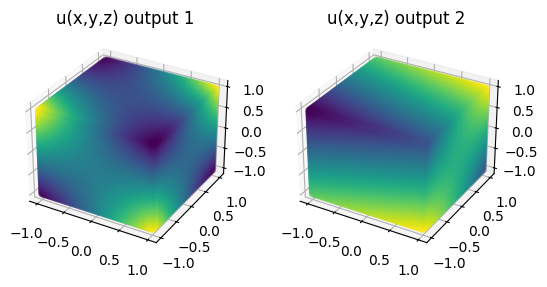

In [43]:
# plotting the function u
interactive_plots=False
if interactive_plots:
    x = np.linspace(-1, 1, 50)
    y = np.linspace(-1, 1, 50)
    z = np.linspace(-1, 1, 50)
    X, Y, Z = np.meshgrid(x, y, z)
    X = X.flatten()
    Y = Y.flatten()
    Z = Z.flatten()
    input = torch.tensor(np.array([X, Y, Z]).T, dtype=torch.float32)
    output = u(input)
    fig = px.scatter_3d(x=X, y=Y, z=Z, color=output[:, 0])
    fig.update_traces(marker=dict(size=3))
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.update_layout(title='u(x,y,z) output 1')
    fig.show()
    fig = px.scatter_3d(x=X, y=Y, z=Z, color=output[:, 1])
    fig.update_traces(marker=dict(size=3))
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.update_layout(title='u(x,y,z) output 2')
    fig.show()
else:
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    x = np.linspace(-1, 1, 50)
    y = np.linspace(-1, 1, 50)
    z = np.linspace(-1, 1, 50)
    X, Y, Z = np.meshgrid(x, y, z)
    X = X.flatten()
    Y = Y.flatten()
    Z = Z.flatten()
    input = torch.tensor(np.array([X, Y, Z]).T, dtype=torch.float32)
    output = u(input)
    fig = plt.figure()
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(X, Y, Z, c=output[:, 0])
    ax.set_title('u(x,y,z) output 1')
    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(X, Y, Z, c=output[:, 1])
    ax.set_title('u(x,y,z) output 2')
    plt.show()

---

## Experimenting with torch autograd

If u is a function of the scaled inputs, but we need to compute the gradient of u wrt the true inputs, then we need to recreate leaf features for the input properly

2 simple pipelines

In [44]:
x = torch.ones(3, 1).detach().requires_grad_(True).to("cuda:0")
y = 3*torch.ones(3, 1).detach().requires_grad_(True).to("cuda:0")
output = torch.cat([torch.tensor(5).to("cuda:0")*x**2, y, x*y], 1)

ux, uy, uz = output[:,0], output[:,1], output[:,2]
torch.autograd.grad(ux, x, grad_outputs=torch.ones_like(ux), create_graph=True)[0]
torch.autograd.grad(uz, x, grad_outputs=torch.ones_like(uz), create_graph=True)[0]

tensor([[3.],
        [3.],
        [3.]], device='cuda:0', grad_fn=<AddBackward0>)

In [45]:
w1 = torch.ones(3, 3).to("cuda:0")
w2 = torch.ones(3, 3).to("cuda:0")
w3 = torch.ones(3, 3).to("cuda:0")
w4 = torch.ones(3, 3).to("cuda:0")
w5 = torch.ones(3, 3).to("cuda:0")
w6 = torch.ones(3, 3).to("cuda:0")

z = torch.cat([w1@x, w2@x, w3@x], 1)
w = torch.cat([w4@x, w5@x, w6@x], 1)

t = z@w.T
torch.autograd.grad(t[:,0], x, grad_outputs=torch.ones_like(t[:,0]), create_graph=True)[0]

tensor([[54.],
        [54.],
        [54.]], device='cuda:0', grad_fn=<AddBackward0>)

Some more complex pipeline

In [46]:
# the variables for which I want to find the gradients
x_true = 6*torch.randn(3, 1).requires_grad_(True).to(device='cuda:0')
y_true = 3*torch.randn(3, 1).requires_grad_(True).to(device='cuda:0')
z_true = 2*torch.randn(3, 1).requires_grad_(True).to(device='cuda:0')

In [47]:
# scaling the variables
x_mean = torch.mean(x_true).detach().to(device='cuda:0')
y_mean = torch.mean(y_true).detach().to(device='cuda:0')
z_mean = torch.mean(z_true).detach().to(device='cuda:0')

x_std = torch.std(x_true).detach().to(device='cuda:0')
y_std = torch.std(y_true).detach().to(device='cuda:0')
z_std = torch.std(z_true).detach().to(device='cuda:0')

x = (x_true - x_mean) / x_std
y = (y_true - y_mean) / y_std
z = (z_true - z_mean) / z_std

# computing the output
output = u(torch.cat([x, y, z], 1))

In [48]:
def function_of_gradient(output, x_true, y_true, z_true):
    outputx, outputy = output[:, 0], output[:, 1]
    
    # first order derivatives
    grad_outputx_x = torch.autograd.grad(outputx, x_true, grad_outputs=torch.ones_like(outputx), create_graph=True, retain_graph=True)[0]
    grad_outputx_y = torch.autograd.grad(outputx, y_true, grad_outputs=torch.ones_like(outputx), create_graph=True, retain_graph=True)[0]

    grad_outputy_y = torch.autograd.grad(outputy, y_true, grad_outputs=torch.ones_like(outputy), create_graph=True, retain_graph=True)[0]
    grad_outputy_z = torch.autograd.grad(outputy, z_true, grad_outputs=torch.ones_like(outputy), create_graph=True, retain_graph=True)[0]

    # second order derivatives
    grad_outputx_xy = torch.autograd.grad(grad_outputx_x, y_true, grad_outputs=torch.ones_like(grad_outputx_x), create_graph=True, retain_graph=True)[0]
    grad_outputy_yy = torch.autograd.grad(grad_outputy_y, y_true, grad_outputs=torch.ones_like(grad_outputy_y), create_graph=True, retain_graph=True)[0]

    # computing the sum
    sum = grad_outputx_x + grad_outputy_y + grad_outputx_y + grad_outputy_z + grad_outputx_xy + grad_outputy_yy

    return torch.mean(sum**2)

function_of_gradient(output, x_true, y_true, z_true)

tensor(35.7043, device='cuda:0', grad_fn=<MeanBackward0>)

---

Adapting the training pipeline

In [49]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, n_samples=1000):
        self.n_samples = n_samples
        x = np.random.uniform(-1, 1, size=(n_samples, 3))
        self.x = torch.tensor(x, dtype=torch.float32)

        self.y = u(self.x)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# create a neural network
class Net(nn.Module):
    def __init__(self, input_size=2, output_size=1):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 30)
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30, output_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [50]:
class PINN_loss():
    def __init__(self, data_loss_fn, lbda_physics, device):
        self.lbda_physics = lbda_physics
        self.device = device
        self.data_loss_fn = data_loss_fn
    
    def __call__(self, output, target, x_true, outputx_std, outputx_mean, outputy_std, outputy_mean):
        # data loss
        loss_data = self.data_loss_fn(output, target)

        # unscaling output
        ux = output[:, 0]*outputx_std + outputx_mean
        uy = output[:, 1]*outputy_std + outputy_mean

        grad_ux_x = torch.autograd.grad(inputs=x_true,
                               outputs=ux,
                               grad_outputs=torch.ones_like(ux),
                               create_graph=True)[0]
        loss_physics = torch.mean((grad_ux_x - uy)**2)
        
        # total loss
        total_loss = loss_data + self.lbda_physics*loss_physics

        return total_loss, loss_data, loss_physics

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = Dataset(n_samples=10000)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10000, shuffle=True)

# compute std and mean of input in dataset
x_mean = torch.mean(dataset.x[:, 0]).clone()
y_mean = torch.mean(dataset.x[:, 1]).clone()
z_mean = torch.mean(dataset.x[:, 2]).clone()

x_std = torch.std(dataset.x[:, 0]).clone()
y_std = torch.std(dataset.x[:, 1]).clone()
z_std = torch.std(dataset.x[:, 2]).clone()

# scale dataset
dataset.x[:, 0] = (dataset.x[:, 0] - x_mean) / x_std
dataset.x[:, 1] = (dataset.x[:, 1] - y_mean) / y_std
dataset.x[:, 2] = (dataset.x[:, 2] - z_mean) / z_std

# compu mean and std of output in dataset
outputx_mean = torch.mean(dataset.y[:, 0]).clone()
outputy_mean = torch.mean(dataset.y[:, 1]).clone()

outputx_std = torch.std(dataset.y[:, 0]).clone()
outputy_std = torch.std(dataset.y[:, 1]).clone()

# scale dataset
dataset.y[:, 0] = (dataset.y[:, 0] - outputx_mean) / outputx_std
dataset.y[:, 1] = (dataset.y[:, 1] - outputy_mean) / outputy_std

In [52]:
# model
model = Net(input_size=3, output_size=2).to(device)

# loss function
lbda_physics = 20
loss_fn = PINN_loss(data_loss_fn = torch.nn.MSELoss(), lbda_physics=lbda_physics, device=device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

list_loss = []
list_loss_physics = []
list_loss_data = []

# train the model
n_epochs = 100
for epoch in tqdm(range(n_epochs)):
    for i, (input, target) in enumerate(dataloader):
        optimizer.zero_grad()

        input, target = input.to(device), target.to(device)
        
        x_true = (x_std*input[:, 0] + x_mean).detach().requires_grad_(True).view(-1, 1).to(device)
        y_true = (y_std*input[:, 1] + y_mean).detach().requires_grad_(True).view(-1, 1).to(device)
        z_true = (z_std*input[:, 2] + z_mean).detach().requires_grad_(True).view(-1, 1).to(device)

        x,y,z = (x_true - x_mean)/x_std, (y_true - y_mean)/y_std, (z_true - z_mean)/z_std
        
        input = torch.hstack([x, y, z])
        output = model(input)
        

        loss, loss_data, loss_physics = loss_fn(output, target, x_true, outputx_std, outputx_mean, outputy_std, outputy_mean)

        list_loss.append(loss.item())
        list_loss_physics.append(loss_physics.item())
        list_loss_data.append(loss_data.item())

        #pinn_loss = physics_loss(input, output)
        loss.backward()
        optimizer.step()

100%|██████████| 100/100 [00:06<00:00, 14.33it/s]


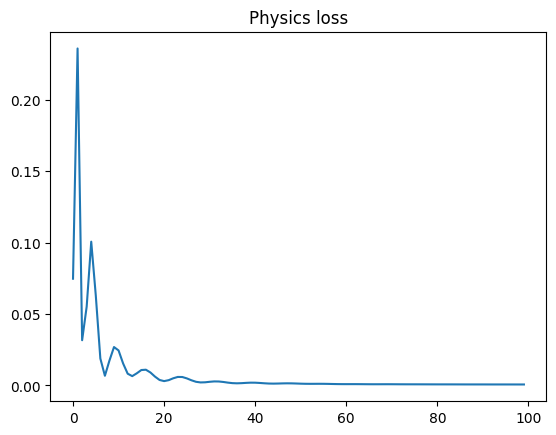

In [53]:
#plot loss pinn
if interactive_plots:
    df = pd.DataFrame(list_loss_physics, columns=["loss"])
    fig = px.line(df, title="Physics loss")
    fig.update_layout(template="plotly_dark")
    fig.show()
else:
    import matplotlib.pyplot as plt
    plt.plot(list_loss_physics)
    plt.title('Physics loss')
    plt.show()

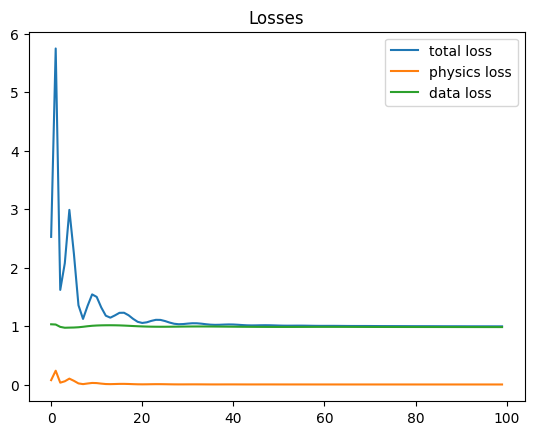

In [54]:
if interactive_plots:
    df = pd.DataFrame({'loss': list_loss, 'loss_pinn': list_loss_physics, 'loss_data': list_loss_data})
    fig = px.line(df, title="Losses")
    fig.update_layout(template="plotly_dark")
    fig.show()
else:
    import matplotlib.pyplot as plt
    plt.plot(list_loss, label='total loss')
    plt.plot(list_loss_physics, label='physics loss')
    plt.plot(list_loss_data, label='data loss')
    plt.legend()
    plt.title('Losses')
    plt.show()

In [56]:
#plot results
if interactive_plots:
    input = torch.tensor(np.array([X, Y, Z]).T, dtype=torch.float32)
    output = model(input)
    fig = px.scatter_3d(x=X, y=Y, z=Z, color=output[:, 0])
    fig.update_traces(marker=dict(size=3))
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.update_layout(title='u(x,y,z) output 1')
    fig.show()
    fig = px.scatter_3d(x=X, y=Y, z=Z, color=output[:, 1])
    fig.update_traces(marker=dict(size=3))
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.update_layout(title='u(x,y,z) output 2')
    fig.show()
else:
    x = np.linspace(-1, 1, 50)
    y = np.linspace(-1, 1, 50)
    z = np.linspace(-1, 1, 50)
    X, Y, Z = np.meshgrid(x, y, z)
    X = X.flatten()
    Y = Y.flatten()
    Z = Z.flatten()
    input = torch.tensor(np.array([X, Y, Z]).T, dtype=torch.float32)
    output = model(input)
    fig = plt.figure()
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(X, Y, Z, c=output[:, 0].detach().numpy())
    ax.set_title('u(x,y,z) output 1')
    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(X, Y, Z, c=output[:, 1].detach().numpy())
    ax.set_title('u(x,y,z) output 2')
    plt.show()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

---

In [38]:
# playground
x = torch.randn(100, 4, 2)
y = torch.randn(100, 4)
index = torch.argmin(y, dim=1)
out = torch.gather(x, dim=1, index=index.view(-1,1).unsqueeze(-1).expand(-1, -1, 2)).squeeze()
x, index, out

(tensor([[[-3.6044e+00, -1.0751e-01],
          [ 5.6637e-01, -1.6966e+00],
          [-1.5686e-01,  1.1371e+00],
          [-3.9253e-01,  2.5145e-01]],
 
         [[ 2.0930e-01, -9.8520e-01],
          [-8.2460e-01,  2.1045e+00],
          [ 8.4229e-02, -4.0307e-01],
          [ 3.1381e-01,  4.6798e-01]],
 
         [[ 3.4714e-02,  3.6210e-01],
          [ 6.7977e-01,  7.0521e-01],
          [-4.6069e-01,  5.7327e-01],
          [ 4.4564e-01, -5.9491e-01]],
 
         [[-1.5817e+00,  1.0522e+00],
          [-7.9748e-01, -1.4933e+00],
          [-1.4919e+00, -4.5379e-01],
          [-1.0700e-02, -1.5132e+00]],
 
         [[-4.2522e-01, -1.1188e+00],
          [-2.6084e-01,  8.7324e-01],
          [-1.6010e+00,  8.6514e-01],
          [ 6.0496e-01,  9.6063e-02]],
 
         [[-2.1537e-01,  5.4201e-01],
          [-2.7607e-02, -6.5792e-01],
          [ 5.8320e-01,  1.7819e-01],
          [-1.7717e-02, -1.3004e+00]],
 
         [[ 1.2269e+00, -3.2412e-01],
          [ 1.0308e+00, -4.7353e